### Install libraries from terminal:

Open your terminal in the project's root directory and run:

`pip install -r requirements.txt` 

This will install all the libraries listed in requirements.txt in your project's environment.

### Install Libraries from here:

In [1]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Add environment variables.

#### openai_api_key
In our configuration (.zshrc) file for Zsh (Z Shell), we add:
```bash
export OPENAI_API_KEY="your-open-ai-api-key"
```



### Import Libraries

In [1]:
# Standard Libraries
import os
import operator
from base64 import b64encode
from IPython.display import Image, display

# Third Party Libraries
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import Graph, StateGraph, START, END
from typing import Literal
from Models.validation import Validation, parse_ai_message_to_validation
from Models.translation import Translation, parse_ai_message_to_translation
from Models.state import State
from Models.xml_formatter import to_xml
# from helpers import to_markdown

### Initialize an OpenAI model

In [2]:
llm = ChatOpenAI(
    name="gpt-4o",
    temperature=0.3
)

### Validate the input

In [3]:
def validate(state):
    """
    Validates the language of the input text and updates the state.
    """

    user_input = state.messages[-1]
    
    prompt = f"""
    You are a language detection expert and a translation assistant.  
    Your task is to identify whether the user input is a translation request and determine the source and target languages.

    **Input:** {user_input}

    **Instructions:**
    - If the input is asking how to say something in another language
    (e.g., "How do you say [text] in [language]?", "Translate [text] to [language]"), consider it a translation request.
    - For a translation request:
        - Set `translate=True`.
        - Set `text` to the input query.
        - Detect the source and target languages based on the query.
        - The source language is assumed to be "en" (English) by default if not explicitly specified.
        - The target language is determined by the language mentioned in the query
        (e.g., "Spanish" in the phrase "How do you say hello in Spanish?").
        
    - If the input is not a translation request, output:
      - source_language = "unknown"
      - target_language = "unknown"
      - translate = False
      - text = ""

    **Example:**
    Input: "How do you say get up in Spanish?"
    Output: 
        source_language = "en"
        target_language = "es"
        translate = True
        text = "How do you say get up in Spanish?"
    """
    user = HumanMessage(content=prompt)
    state.messages.append(user)
    response = llm.invoke([user])
    print(response)
    validation = parse_ai_message_to_validation(response)
    # print(f"response_llm: {response_llm}")
    # structured_llm = llm.with_structured_output(Validation, method="function_calling")
    # response = structured_llm.invoke(state.messages) # [user]
    #ai_message = response.to_ai_message()
    state.messages.append(response) 
    state.validation = validation
    print(validation)
    return state
    

### Translate

In [4]:
def translate(state):
    """
    Translate text from the source language to the target language of a given text.
    """
    source_language = state.validation.source_language
    target_language = state.validation.target_language
    text_to_translate = state.validation.text_to_translate()
    given_text = state.validation.text
    
    prompt = f"""You are a world-class translator. Translate the given text from {source_language} to {target_language}. 
    Given text: 
    {text_to_translate}

    Please provide the response in the following format:

    given_text: {given_text}
    translated_text: <translated_text_here>
    
    """

    user = HumanMessage(content=prompt)
    state.messages.append(user)
    response = llm.invoke([user])
    print(f"translate response: {response}")
    translation = parse_ai_message_to_translation(response)
    # structured_llm = llm.with_structured_output(Translation)
    # response = structured_llm.invoke([user])
    state.messages.append(response)
    state.translation = translation
    print(f"translation: {translation}")
    return state
    

### Route Chooser

In [5]:
def route_chooser(state) -> Literal["translator", END]:
    print("route_chooser")
    return "translator" if state.validation.translate else END

### Draw the graph

In [6]:
def draw_graph(grap):
    display(Image(app.get_graph().draw_mermaid_png()))

### Create the graph

In [7]:
graph = StateGraph(State)

# Nodes
graph.add_node("validator", validate)
graph.add_node("translator", translate)
graph.add_node("formatter", to_xml)

# Edges or Conditional Edges
graph.add_edge(START, "validator")
graph.add_edge("translator", "formatter")
graph.add_conditional_edges("validator", route_chooser)
graph.add_edge("formatter", END)

app = graph.compile()

### Display the graph

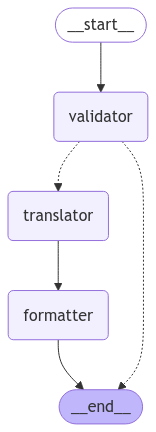

In [8]:
draw_graph(app)

### Enjoy the app

In [9]:

state = State(
    messages=[HumanMessage(content="How do you say hi in Spanish?")],
    validation=None,
    translation=None
)
thread = {"configurable": {"thread_id": "1"}}
response = app.invoke(state, thread)  # Call the app with the updated state

content='**Output:**\n    source_language = "en"\n    target_language = "es"\n    translate = True\n    text = "How do you say hi in Spanish?"' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 310, 'total_tokens': 346, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-55199936-29a5-4be0-88a2-5f8db9a1e3ab-0' usage_metadata={'input_tokens': 310, 'output_tokens': 36, 'total_tokens': 346, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
string
string
bool
string
source_language='en' target_language='es' translate=True text='How do you say hi in Spanish?'
route_chooser
translate response: content='given_